<a href="https://colab.research.google.com/github/RamySaleem/Creating-Synthetic-Seismic-from-Coalmines-Cross-sections-/blob/main/Synthetic_Seismic_Notebook_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Synthetic Seismic Modelling of Geological Interpretations**
==============================================
**Using Coalmines Subsurface Cross-sections from**
=========================================
**Ruhr Sub Basin, Lower Rhine Basin, Germany**
======================================

![Synthetic Seismic Section](https://i.imgur.com/xFOw79c.png)

Introduction
==========
Seismic data provide a “time picture” of subsurface structure. 2D reflection seismic data provide cross-sectional views in both the dip and strike directions. Data on the lines are a mixture of both in-plane and out-of-plane reflectors. 2D reflection seismic data are most important in the earlier stages of an exploration program, especially in frontier basins.

Seismic imaging is the key method for imaging the structure of the subsurface. Data are generated by sending acoustic energy (sound waves) into the Earth and recording the reflections which are returned from the various layers. Seismic imaging is used extensively in the petroleum industry and also in mining, civil engineering and hydro-geology.
https://wiki.aapg.org/Seismic_data

Synthetic Seismic Data
===================
Synthetic seismic data is artificial data generated using forward modelling to replicate the subsurface geological structures. We use interpreted geological cross-sections to generate the synthetic data in this case.
https://wiki.aapg.org/Synthetic_seismogram

Aims
====
The aims of this project are:

1.	Develop a python code to generate synthetic seismic data from vector images.
2.	Produce a suite of synthetic seismic sections from coalmines data in the Ruhr subbasin, lower Rhine basin, Germany.

Methods
=======
1.	Build the stratigraphic model of the area.
2.	Get the lithology of each cross-section from the stratigraphic model
3.	Select average stander velocities and densities for each lithology
4.	Calculate the acoustic impedance by multiplying the density of the rocks by the velocity of the rocks (vp * rho)
5.	Calculate reflection coefficients, Ro. The reflection coefficient is the acoustic impedance of the upper layer subtracted from the lower layer divided by the sum of the two. 
6.	Convolve the reflection coefficient series with the Ricker wavelet.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4243db6b3dab87b7be571c98f8f7568824ad4a6a)


Ruhr Coalmines DataSet
=====================
**Area-1 Summary**

The study area is explored by high-resolution, closely spaced, coal mines with an aerial extent of 323.29 km2 and a depth of 2 km. The subsurface data are provided by mine-workings (galleries, adits and shafts) as well as accompanying boreholes and seismic reflection profiles, which are supported by surface exposure enhanced by open-cast pits. These data were interpreted by Drozdzewski et al. (1980), who reported these observations and erected their own geological interpretations on a series of paper maps and cross-sections. 

They are a set of 12 serial cross-sections with a spacing of 1 to 2 km and tied by two cross-lines. Further, Drozdzewski et al. (1980) indicate the levels of confidence in their interpretations critically using descriptive criteria. The stratigraphic column present in this study is put together and generated after Drozdzewski et al. (1980), Drozdzewski (1993), Suess et al. (2007), Cleal et al. (2009) and Uhl and Cleal (2010). The lithology, formations names, coal seams and stratigraphic units in this stratigraphic column are constrained by correlating the stratigraphic units from Drozdzewski et al. (1980) to other recent studies (e.g. Cleal et al. 2009; Uhl and Cleal 2010). 

**Dataset can be found in the following links:**
1. **Interpreted Images** https://drive.google.com/drive/folders/1j4PBXQyVx89rkVTvMS7Yjl7e7y5OTDrC?usp=sharing
2. **Digitised Cross Sections** https://drive.google.com/drive/folders/1EabQCWqC1JExdLTRCJRx8MDAGHAhHy5N?usp=sharing




Results
======
1. Generate an ML dataset for testing subsurface interpretations
2. Generate a dataset of synthetic seismic images which can be used for educational peruses
3. Develop workflows for building synthetic seismic sections
4. Generate a dataset to develop ML Workflow for efficient classification of structures using object detection
5. Compare actual and synthetic seismic data from coalmines data in the Ruhr subbasin, lower Rhine basin, Germany.

**Results images can be found in the following links:**
1. **Acoustic Impedance Sections** https://drive.google.com/drive/folders/1ANce0auhTOXS0lcIoMfbTcG2r4lTdgfX?usp=sharing
2. **Synthetic Seismic Sections** https://drive.google.com/drive/folders/1C6TAHjFPzltrU4nS1oeHeEdBsEVkWzDM?usp=sharing

Future work
===========
To develop a workflow and web-based front end for the script, which will allow the rapid upload of geological data into the forward seismic modelling to generate synthetic seismic data.


## Import Libraries

In [128]:
# %matplotlib widget
%matplotlib inline

import re
import os
import cv2
import glob
from pathlib import Path
import bruges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Workflow Examples Section-1

Reading the image file and performing image processing techniques. First, make the image grey, get the edge and then digitise the image.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
img=cv2.imread(r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-1/Tafel_24_Section_1_Emscher_West_Ruhrgebit_G1.png')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 75, 150, apertureSize = 3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

Getting the digitise horizons from the image by getting the x and y values.

In [8]:
img2=img

if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2-y1)==0 and abs(x2-x1)>2:
                cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)
img2 = img
test_1 = cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)

Splitting the x and z values for each horizons in the section.

In [9]:
x = []
for i in range(len(lines)):
    for j in (0, 2):
        x.append(lines[i][0][j])
z = []
for i in range(len(lines)):
    for j in (1, 3):
        z.append(lines[i][0][j])

After getting the data, we apply the scale factor to the x, y and z directions and then store the data in a data frame to make it organised.

In [13]:
# Scale the data in the x direction
scale_factor_x = 2
# Scale the data in the z direction and correct for the depth
scale_factor_z = -7
depth_correction = 400
# Creating the y data using the x data since the section digitised in two direction (x, z)

d = {'x' : x, 'z' : z}
xyz_int_df = pd.DataFrame(d)
xyz_int_df['x'] = xyz_int_df['x'] * scale_factor_x
xyz_int_df['z'] = (xyz_int_df['z'] * scale_factor_z) + depth_correction
xyz_int_df['y'] = (xyz_int_df['x']) / scale_factor_x*2

Plotting the raw image with the interpreted horizons

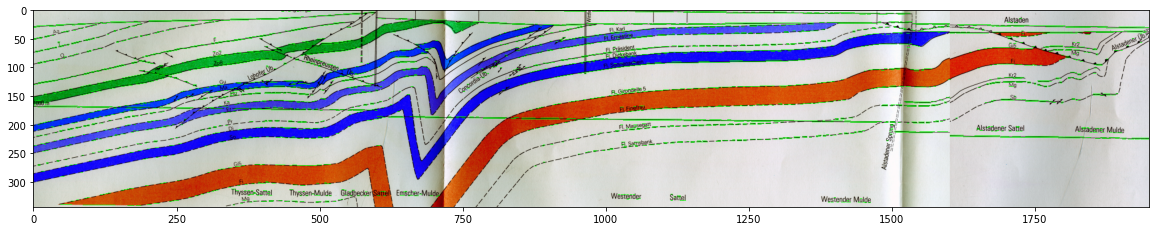

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(img);

Plotting the image on grey scale.

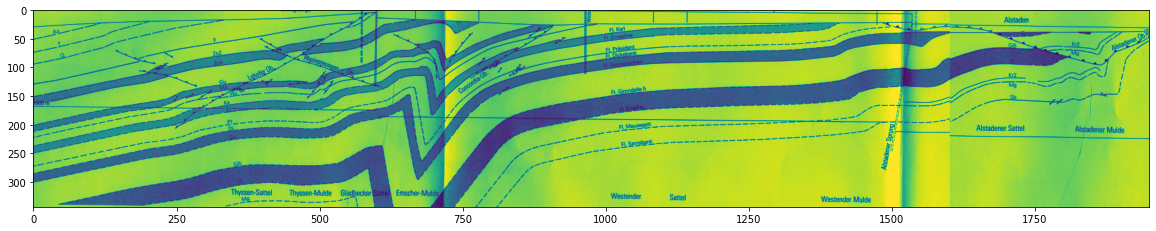

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(gray);

Appling edge detiction filter to the image then use it for digitisation the horizons

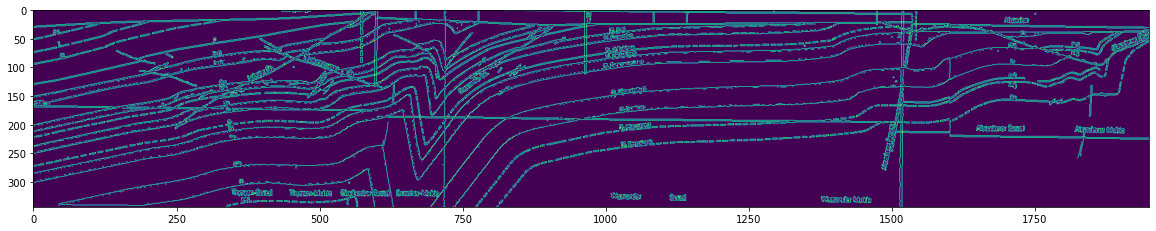

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(edges);

Later we use the OpenCV function Laplacian() to implement a discrete analog of the Laplacian operator. For more info check https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html

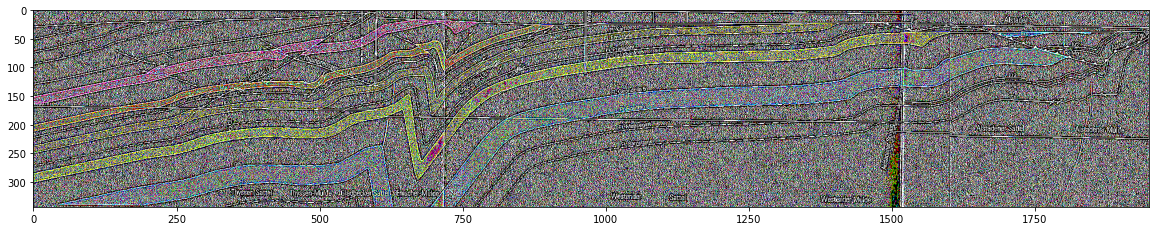

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(laplacian);

Moreover we applied sobel filterin the x direction.

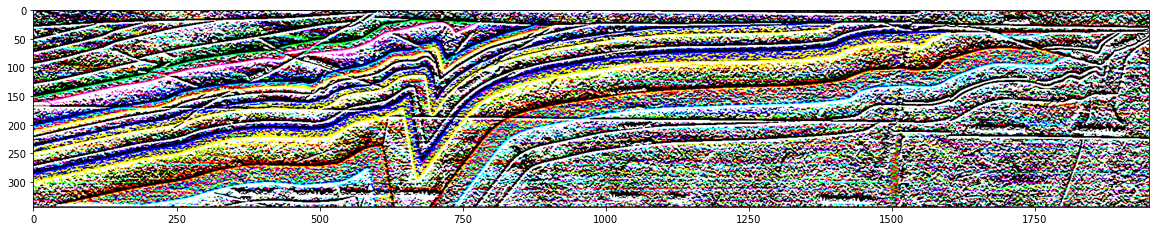

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(sobely);

Plot the final digitisation result. Notice the horizons, faults and vertical boreholes and horizontal wells.

In [19]:
chart_title ="Digitised Geological Section No.1" + "\nGenerated from Coalmines Geological Interpretation" + "\nCoalmines Dataset from Ruhr Sub Basin, Lower Rhine Basin, Germany" 

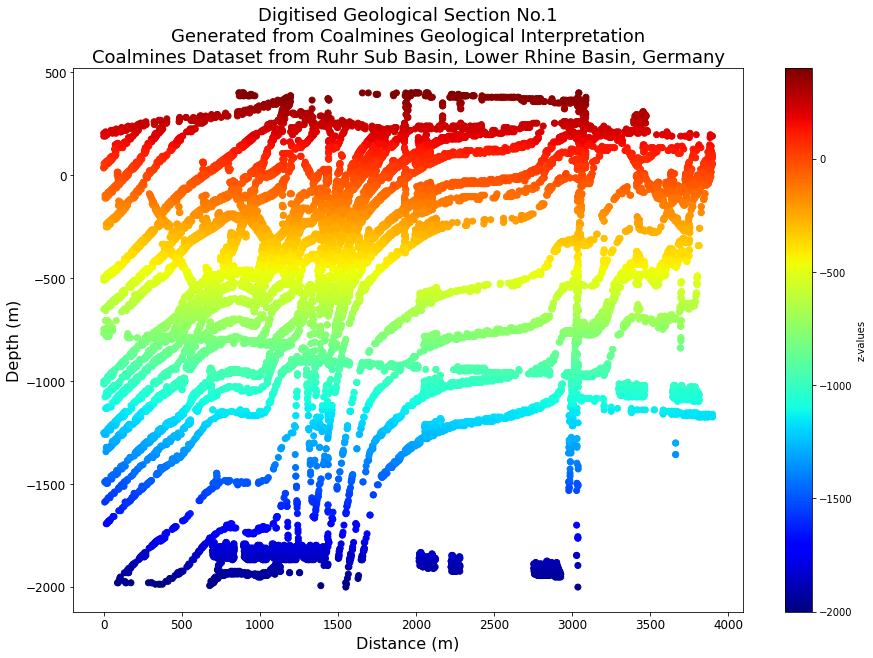

In [20]:
# Headline title
text = chart_title
# Decorations
plt.title(chart_title, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

im = plt.scatter(xyz_int_df['x'], xyz_int_df['z'], c=xyz_int_df['z'],cmap="jet")
plt.colorbar(im, label="z-values")
plt.xlabel("x")
plt.ylabel("z");


fig_size = plt.gcf().get_size_inches() #Get current size
sizefactor = 2.5 #Set a zoom factor
# Modify the current size by the factor
plt.gcf().set_size_inches(sizefactor * fig_size) 
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Depth (m)', fontsize=16);

Lastly, we plot the constructed raw image with the digitised results.

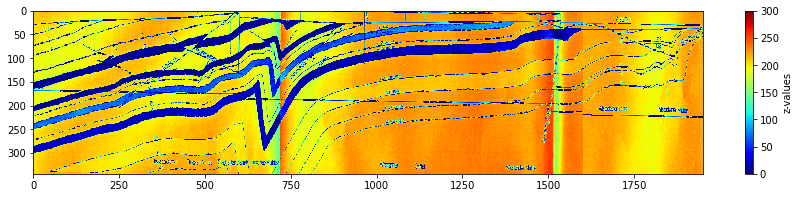

In [21]:
plt.figure(figsize=(15, 3))
plt.pcolormesh(test_1[:,:,0], cmap="jet", clim=[0,300]) # , clim=[-1, 1]
plt.gca().invert_yaxis()
plt.colorbar(label="z-values");

Here we put together two helper functions to apply the above-created workflow and apply it to the data set.

In [22]:
def digitise_section(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 75, 150, apertureSize = 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50)
    
    img2=img
    if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(y2-y1)==0 and abs(x2-x1)>2:
                    cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)
    img2 = img
    test_1 = cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    x = []
    for i in range(len(lines)):
        for j in (0, 2):
            x.append(lines[i][0][j])
    z = []
    for i in range(len(lines)):
        for j in (1, 3):
            z.append(lines[i][0][j])
    
    d = {'x' : x, 'z' : z}
    xyz_int_df = pd.DataFrame(d)
    xyz_int_df['x'] = xyz_int_df['x'] * 2
    xyz_int_df['z'] = (xyz_int_df['z'] * -7) + 400
    xyz_int_df['y'] = (xyz_int_df['x']) / -4
    
    return xyz_int_df

In [23]:
def digitise_data_section(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 75, 150, apertureSize = 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50)
    
    img2=img
    if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(y2-y1)==0 and abs(x2-x1)>2:
                    cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)
    img2 = img
    test_1 = cv2.line(img2, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    x = []
    for i in range(len(lines)):
        for j in (0, 2):
            x.append(lines[i][0][j])
    z = []
    for i in range(len(lines)):
        for j in (1, 3):
            z.append(lines[i][0][j])
    
    d = {'x' : x, 'z' : z}
    xyz_int_df = pd.DataFrame(d)
    xyz_int_df['x'] = xyz_int_df['x'] * 2
    xyz_int_df['z'] = (xyz_int_df['z'] * -7) + 400
    xyz_int_df['y'] = (xyz_int_df['x']) / -4
    
    return test_1[:,:,0]

In [24]:
def stretch_arr(arr_input, arr_ref):
    """
    The input array should be 1D as x or y
    """
    arr_x_interp = interp.interp1d(np.arange(arr_input.size),arr_input.reshape(arr_input.shape[0]))
    arr_x_stretch = arr_x_interp(np.linspace(0,arr_input.size-1,arr_ref.shape[0]))
    return arr_x_stretch

Now let us read the data and digitise the sections and store the data in a dictionary.

In [125]:
folder_dir = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-1'

img_data = {}
sec_data = {}
sections_names = []
word=r"Section"
lword=len(word)
for image in glob.iglob(f'{folder_dir}/*'):
    if (image.endswith(".png")):
        a = image.split("\\")[-1]
        a = a.split(".")[1]
        start_index=re.search(word,a).start()
        # print(a)
        sections_names.append(a[start_index:start_index+lword+4])
        #  img_data[a[start_index:start_index+lword+4]] = digitise_section(cv2.imread(image))
        sec_data[a[start_index:start_index+lword+4]] = digitise_data_section(cv2.imread(image))

The folder include 14 cross sections.

In [129]:
len(sec_data)

14

## Methods

### 1. Build Stratigraphic Model 

We read the data from the csv file that have all the sections, formations and lithology.

In [56]:
fault_data_df = pd.read_csv(r'/content/drive/MyDrive/data/disp-dist-data.csv')

We don't need all the data in the file so we are going to select three columns (Section names, fault names and Horizon names) that are important for building the stratigraphic model.

In [57]:
fault_df = fault_data_df[['FaultName', 'Name', 'HorizonName']]
fault_df

FaultName Name HorizonName
0    Sc_8_F_8   f1         F-2
1    Sc_8_F_8   f1         Zo2
2    Sc_8_F_8   f1         Zo8
3    Sc_8_F_8   f1          Gu
4    Sc_8_F_8   f1          Ma
..        ...  ...         ...
843   SC_F_Md  f99          Ma
844   SC_F_Md  f99          Hu
845   SC_F_Md  f99          Ka
846   SC_F_Md  f99          Er
847   SC_F_Md  f99          Pr

[848 rows x 3 columns]

### 2. Getting the lithology of each cross-section from the stratigraphic model

Moreover we read the lithology for each section and then merge it for each section.

In [58]:
litho_df = pd.read_csv(r'/content/drive/MyDrive/data/lithology-fault-data.csv')
litho_df

HorizonName                   Lithology           Colour FormationName
0            T                   claystone           Silver         Horst
1            Q                   claystone        SlateGray         Horst
2          Q-1                   claystone             gray         Horst
3            N               Rhyolite tuff                r         Horst
4            F  sandstone with siltstones           hotpink         Horst
5          F-2               Rhyolite tuff           Salmon         Horst
6          Zo2               Rhyolite tuff        FireBrick         Essen
7          Zo8               Rhyolite tuff                r         Essen
8           La            coarse sandstone       SandyBrown         Essen
9           Gu            coarse sandstone                y         Essen
10          Ma  sandstone with siltstones          DeepPink         Essen
11        Hu-1  sandstone with siltstones              pink         Essen
12          Hu  sandstone with siltstones   MediumVioletRed         Essen
13          Ka  sandstone with siltstones        LightCoral        Bochum
14          Er               Rhyolite tuff                r        Bochum
15          Pr               Rhyolite tuff          DarkRed        Bochum
16          Di               Rhyolite tuff                r        Bochum
17          So  sandstone with siltstones              pink        Bochum
18          Pl  sandstone with siltstones              pink        Witten
19         Gi5               Rhyolite tuff                r        Witten
20          Fi            coarse sandstone                y        Witten
21         Ge1  sandstone with siltstones              pink        Witten
22        Kr-2            coarse sandstone                y        Witten
23          Mg                   claystone          DimGray        Witten
24          Sb               Rhyolite tuff                r   Sprockhovel
25          Hf                   claystone        RosyBrown   Sprockhovel
26          Wb                   claystone         DarkCyan       Kasberg
27          Gs            coarse sandstone                y       Kasberg

In [59]:
lithology_df = pd.merge(fault_df, litho_df, how="left", on=["HorizonName"])

In [60]:
lithology_df.head()

FaultName Name HorizonName                   Lithology     Colour  \
0  Sc_8_F_8   f1         F-2               Rhyolite tuff     Salmon   
1  Sc_8_F_8   f1         Zo2               Rhyolite tuff  FireBrick   
2  Sc_8_F_8   f1         Zo8               Rhyolite tuff          r   
3  Sc_8_F_8   f1          Gu            coarse sandstone          y   
4  Sc_8_F_8   f1          Ma  sandstone with siltstones    DeepPink   

  FormationName  
0         Horst  
1         Essen  
2         Essen  
3         Essen  
4         Essen

Let us explore the data we have for the lithology.

In [61]:
lithology_df['Lithology'].unique().tolist()

['Rhyolite tuff',
 'coarse sandstone',
 'sandstone with siltstones ',
 'claystone']

We can see that we have four lithologies in the cross sections 'Rhyolite tuff', 'coarse sandstone', 'sandstone with siltstones ' and 'claystone'.

In [62]:
lithology_df['FormationName'].unique().tolist()

['Horst', 'Essen', 'Bochum', 'Witten', 'Sprockhovel', 'Kasberg']

In [63]:
lithology_df['HorizonName'].unique().tolist()

['F-2',
 'Zo2',
 'Zo8',
 'Gu',
 'Ma',
 'Hu',
 'Ka',
 'Er',
 'Pr',
 'F',
 'N',
 'Di',
 'So',
 'Hu-1',
 'Pl',
 'Kr-2',
 'Mg',
 'Sb',
 'Hf',
 'La',
 'T',
 'Q',
 'Q-1',
 'Gi5',
 'Fi',
 'Ge1',
 'Wb',
 'Gs']

In [64]:
lithology_df['FaultName'].unique().tolist()

['Sc_8_F_8',
 'Sc_8_F_10',
 'Sc_8_F_10a',
 'Sc_8_F10_F8',
 'Sc_1_F_9',
 'Sc_1_F_28',
 'Sc_8_F_2',
 'Sc_8_F_3',
 'Sc_8_F_4',
 'Sc_8_F_5',
 'Sc_8_F_6',
 'Sc_8_F_7',
 'Sc_8_F_8a',
 'Sc_8_F_9',
 'Sc_8_F_10b',
 'Sc_8_F_11',
 'Sc_8_F_12',
 'Sc_8_F_15',
 'Sc_8_F_10c',
 'Sc_1_F_9a',
 'Sc_4_F_8',
 'Sc_5_F_8',
 'Sc_9_F_8',
 'Sc_10_F_8',
 'Sc_12_F_8',
 'Sc_11_F_8',
 'Sc_7_F_8',
 'Sc_6_F_8',
 'Sc_9_F_8a',
 'Sc_10_F_8a',
 'Sc_12_F_8c',
 'Sc_8_F_8d',
 'Sc_7_F_10',
 'Sc_7_F_14',
 'Sc_7_F_16',
 'Sc_7_F_7',
 'Sc_6_F_10',
 'Sc_6_F_23',
 'Sc_12_F_3',
 'Sc_12_F_10',
 'Sc_12_F_18',
 'Sc_12_F_23',
 'Sc_12_F_6',
 'Sc_12_F_7',
 'Sc_4_F_23',
 'Sc_1_F_1',
 'Sc_2_F_1',
 'Sc_3_F_1',
 'Sc_4_F_1',
 'Sc_4_F_22',
 'Sc_5_F_22a',
 'Sc_5_F_22b',
 'Sc_5_F_1',
 'Sc_6_F_1',
 'Sc_7_F_1',
 'Sc_8_F_1',
 'Sc_9_F_1',
 'Sc_10_F_1',
 'Sc_11_F_1',
 'Sc_12_F_1',
 'Sc_12_F_3a',
 'Sc_12_F_1a',
 'Sc_12_F_111',
 'Sc_5_F_2',
 'Sc_5_F_2a',
 'Sc_6_F_2',
 'Sc_6_F_2a',
 'Sc_7_F_2',
 'Sc_7_F_2a',
 'Sc_7_F_1a',
 'Sc_7_F_55',
 'Sc_7_F_55a',
 '

### 3. Select average velocities and densities for each lithology

We use the public papers to select average velocities and densities for the lithologies

https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=04d0de8baca4c2b12a47369bd915e1c7323caeb2

Mainly we use the "FORMATION VELOCITY AND DENSITY-THE DIAGNOSTIC BASICS FOR STRATIGRAPHIC TRAPS" by Gardner. 

G. H. F. GARDNER,* L. W. GARDNER,1 AND A. R. GREGORY

### a. Rhyolite tuff rocks

For the Rhyolite Tuff we use the paper for the velocities and densities "Tuff as rock and soil: Review of the literature on tuff geotechnical, chemical and mineralogical properties around the world and in Indonesia"

https://aip.scitation.org/doi/abs/10.1063/1.5112466#:~:text=Tuff%20rock%20has%20geotechnical%20properties,%25%20%2D%2042%25%20of%20porosity.

Durant, G.P. (1989). Rhyolite . In: Petrology. Encyclopedia of Earth Science. Springer, Boston, MA. https://doi.org/10.1007/0-387-30845-8_216

https://link.springer.com/referenceworkentry/10.1007/0-387-30845-8_216#:~:text=Structural%20and%20textural%20features,et%20al.%2C%201974).

### b. Claystone rocks

Mavko, G., Mukerji, T., & Dvorkin, J. (2020). Empirical Relations. In The Rock Physics Handbook (pp. 474-524). Cambridge: Cambridge University Press. doi:10.1017/9781108333016.008

https://www.cambridge.org/core/books/rock-physics-handbook/empirical-relations/A3C47744A7D969387BC95836883F5FA9#

### c. Sandstone with Siltstones

Porosities, velocities, and densities of rocks

https://wiki.seg.org/wiki/Porosities,_velocities,_and_densities_of_rocks

Density of Rocks and Soils

https://chem.libretexts.org/Ancillary_Materials/Exemplars_and_Case_Studies/Exemplars/Geology/Density_of_Rocks_and_Soils#:~:text=For%20example%2C%20sandstone%20(characteristically%20quartzose,is%202.65%20g%2Fcm3.

### d. Coarse Sandstone

For the sandstone we use the "Mechanical Properties and Acoustic Emission Characteristics of Weakly Cemented Sandstone With Different Grain Sizes" by Bin LiuBin LiuTong ZhangHongwei ZhangQiupeng YuanQiupeng Yuan.

The study area is Mining Area with weakly cemented sandstone, which ismainly formed by mineral grains and cemented minerals through compaction and cementation. Which is close to our study area. 

(PDF) Mechanical Properties and Acoustic Emission Characteristics of Weakly Cemented Sandstone With Different Grain Sizes. Available from: https://www.researchgate.net/publication/361686049_Mechanical_Properties_and_Acoustic_Emission_Characteristics_of_Weakly_Cemented_Sandstone_With_Different_Grain_Sizes#fullTextFileContent [accessed Feb 25 2023].

https://www.researchgate.net/publication/361686049/figure/fig4/AS:1173221365825550@1656729179766/Relationship-between-density-of-sandstone-with-different-granularities-and-P-wave_W640.jpg

![](https://www.researchgate.net/publication/361686049/figure/fig4/AS:1173221365825550@1656729179766/Relationship-between-density-of-sandstone-with-different-granularities-and-P-wave_W640.jpg)

Relationship between density of sandstone with differentgranularities and P-wave velocity

https://www.researchgate.net/publication/361686049_Mechanical_Properties_and_Acoustic_Emission_Characteristics_of_Weakly_Cemented_Sandstone_With_Different_Grain_Sizes#fullTextFileContent

After we collect the values of the densities and velocities, we store the data in a dictionary.

In [65]:
lithology_dict = {'Lithology' : lithology_df['Lithology'].unique().tolist()}

In [66]:
lithology_dict['Lithology']

['Rhyolite tuff',
 'coarse sandstone',
 'sandstone with siltstones ',
 'claystone']

In [67]:
lithology_dict['rho'] = [   2400, # rho Rhyolite tuff
                            2050, # coarse sandstone
                            2550, # sandstone with siltstones
                            1200, # claystone
                        ]

In [68]:
lithology_dict['rho']

[2400, 2050, 2550, 1200]

In [69]:
lithology_dict['vp'] = [    4150, # vp Rhyolite tuff
                            750, # coarse sandstone
                            2250, # sandstone with siltstones
                            1500, # claystone
                        ]

In [70]:
lithology_dict['vp']

[4150, 750, 2250, 1500]

we create a dataframe for the vp and rho and merge them with the lithology data we have for each section.

In [71]:
vp_rho_df = pd.DataFrame(lithology_dict)
vp_rho_df

Lithology   rho    vp
0               Rhyolite tuff  2400  4150
1            coarse sandstone  2050   750
2  sandstone with siltstones   2550  2250
3                   claystone  1200  1500

In [72]:
lithology_df.head()

FaultName Name HorizonName                   Lithology     Colour  \
0  Sc_8_F_8   f1         F-2               Rhyolite tuff     Salmon   
1  Sc_8_F_8   f1         Zo2               Rhyolite tuff  FireBrick   
2  Sc_8_F_8   f1         Zo8               Rhyolite tuff          r   
3  Sc_8_F_8   f1          Gu            coarse sandstone          y   
4  Sc_8_F_8   f1          Ma  sandstone with siltstones    DeepPink   

  FormationName  
0         Horst  
1         Essen  
2         Essen  
3         Essen  
4         Essen

In [73]:
data_litho_df = pd.merge(lithology_df, vp_rho_df, how="left", on=["Lithology"])

In [74]:
data_litho_df 

FaultName Name HorizonName                   Lithology           Colour  \
0    Sc_8_F_8   f1         F-2               Rhyolite tuff           Salmon   
1    Sc_8_F_8   f1         Zo2               Rhyolite tuff        FireBrick   
2    Sc_8_F_8   f1         Zo8               Rhyolite tuff                r   
3    Sc_8_F_8   f1          Gu            coarse sandstone                y   
4    Sc_8_F_8   f1          Ma  sandstone with siltstones          DeepPink   
..        ...  ...         ...                         ...              ...   
843   SC_F_Md  f99          Ma  sandstone with siltstones          DeepPink   
844   SC_F_Md  f99          Hu  sandstone with siltstones   MediumVioletRed   
845   SC_F_Md  f99          Ka  sandstone with siltstones        LightCoral   
846   SC_F_Md  f99          Er               Rhyolite tuff                r   
847   SC_F_Md  f99          Pr               Rhyolite tuff          DarkRed   

    FormationName   rho    vp  
0           Horst  2400  4150  
1           Essen  2400  4150  
2           Essen  2400  4150  
3           Essen  2050   750  
4           Essen  2550  2250  
..            ...   ...   ...  
843         Essen  2550  2250  
844         Essen  2550  2250  
845        Bochum  2550  2250  
846        Bochum  2400  4150  
847        Bochum  2400  4150  

[848 rows x 8 columns]

Later we the velocities and densities for each section in the dataset.

In [75]:
rocks_layers = []
for i in range(len(vp_rho_df['vp'].values.tolist())):
    rocks_layers.append([vp_rho_df['vp'].values.tolist()[i], vp_rho_df['rho'].values.tolist()[i]])

In [76]:
rocks_layers = np.array(rocks_layers)

## 4. Calculate the Acoustic Impedance

### Section-1

Let us get an example section, which will be section number 1.

In [80]:
model_1 = sec_data['Section_1']

In [81]:
test = np.where(model_1 > 150, model_1, model_1*0)
test = np.where(((test < 150) | (test > 210)), test, test*0+1)
test = np.where(((test < 210) | (test > 220)), test, test*0+2)
test = np.where(test < 220, test, test*0+3)

In [82]:
model_rck = test.copy()

Plot section-1.

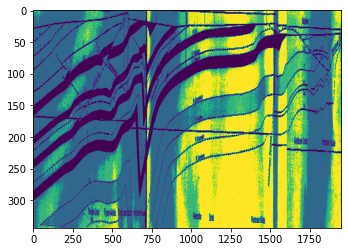

In [83]:
plt.imshow(model_rck, cmap='viridis', aspect=4)
plt.show()

Acoustic impedance (im) = velocity (vp) * density (rho). Here we assign the values of the velocities and densities to each lithology points in the section to calculate the acoustic impedance.

In [84]:
earth = rocks_layers[model_rck]

In [85]:
imp = np.apply_along_axis(np.product, -1, earth)

In [86]:
imp

array([[1537500, 1537500, 5737500, ..., 1800000, 1800000, 5737500],
       [1537500, 1537500, 1537500, ..., 1800000, 1800000, 5737500],
       [5737500, 1537500, 1537500, ..., 1800000, 1800000, 5737500],
       ...,
       [1537500, 1537500, 1537500, ..., 1800000, 1800000, 5737500],
       [1537500, 1537500, 1537500, ..., 1800000, 1800000, 5737500],
       [1537500, 1537500, 1537500, ..., 1800000, 1800000, 1800000]])

## 5. Calculate reflection coefficients, Ro. 

The reflection coefficient is the acoustic impedance of the upper layer subtracted from the lower layer divided by the sum of the two. 

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4243db6b3dab87b7be571c98f8f7568824ad4a6a)

In [88]:
rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])

Plotting the reflection coefficients of the section.

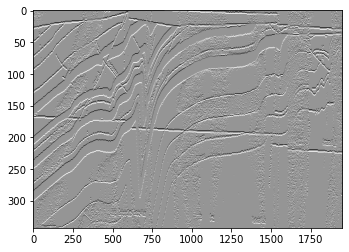

In [89]:
plt.imshow(rc, cmap='Greys', aspect=4)
plt.show()

## 6.Convolve the Reflection Coefficient with the Ricker wavelet

The final step is to simulated the cross section by ricker wavelet. In the step we used **bruges** library to apply the convolution. The simulation can be summarized by the convolutional model:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/77285caad6b11133e3f50409990f9fa465b9b097)


where:

T(t) = seismic trace

R0(t) = reflection coefficient series (spikes)

* = convolution

w(t) = wavelet

n(t) = noise

We use a frequency of 65 Hz to generayte the syenthetic seismic data. The higher frequency's result in better seismic data imaging.

In [90]:
T, dt, f = 0.256, 0.001, 65 # 65 is the f, the higher the better

w, t= bruges.filters.ricker(T, dt, f, return_t=True)

Plotting the Ricker Wavelet.

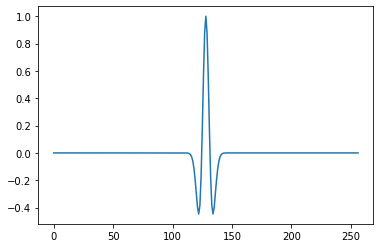

In [91]:
plt.plot(w)
plt.show()

Finally our synthetic section is ready.

In [92]:
synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=1, arr=rc)

In [93]:
synth

array([[ 9.30910546e-04, -4.91486108e-01, -9.67233233e-01, ...,
        -3.27978992e-01, -3.61795011e-01, -3.16092115e-01],
       [ 7.40196114e-01,  1.00455900e+00,  1.11011631e+00, ...,
         5.94810929e-01,  5.31918470e-01,  4.10846587e-01],
       [ 7.40702739e-01,  1.19949709e+00,  1.44429331e+00, ...,
        -3.84274441e-01, -6.59096847e-01, -7.55508964e-01],
       ...,
       [ 3.90518799e-08,  2.13284541e-07,  1.06648036e-06, ...,
         2.94641770e-01,  4.59265992e-01,  5.22388060e-01],
       [ 1.93297174e-12,  1.61401613e-11,  1.23456276e-10, ...,
        -2.94641770e-01, -8.95223457e-02,  8.96326714e-02],
       [-7.55549041e-09, -4.55990079e-08, -2.52318164e-07, ...,
         1.64624222e-01, -1.64624222e-01, -4.32865714e-01]])

## Plotting the final synthetic section.

In [94]:
chart_title ="Syenthetic Seismic Section No.1" + "\nGenerated from Coalmines Geological Interpretation" + "\nCoalmines Dataset from Ruhr Sub Basin, Lower Rhine Basin, Germany" 

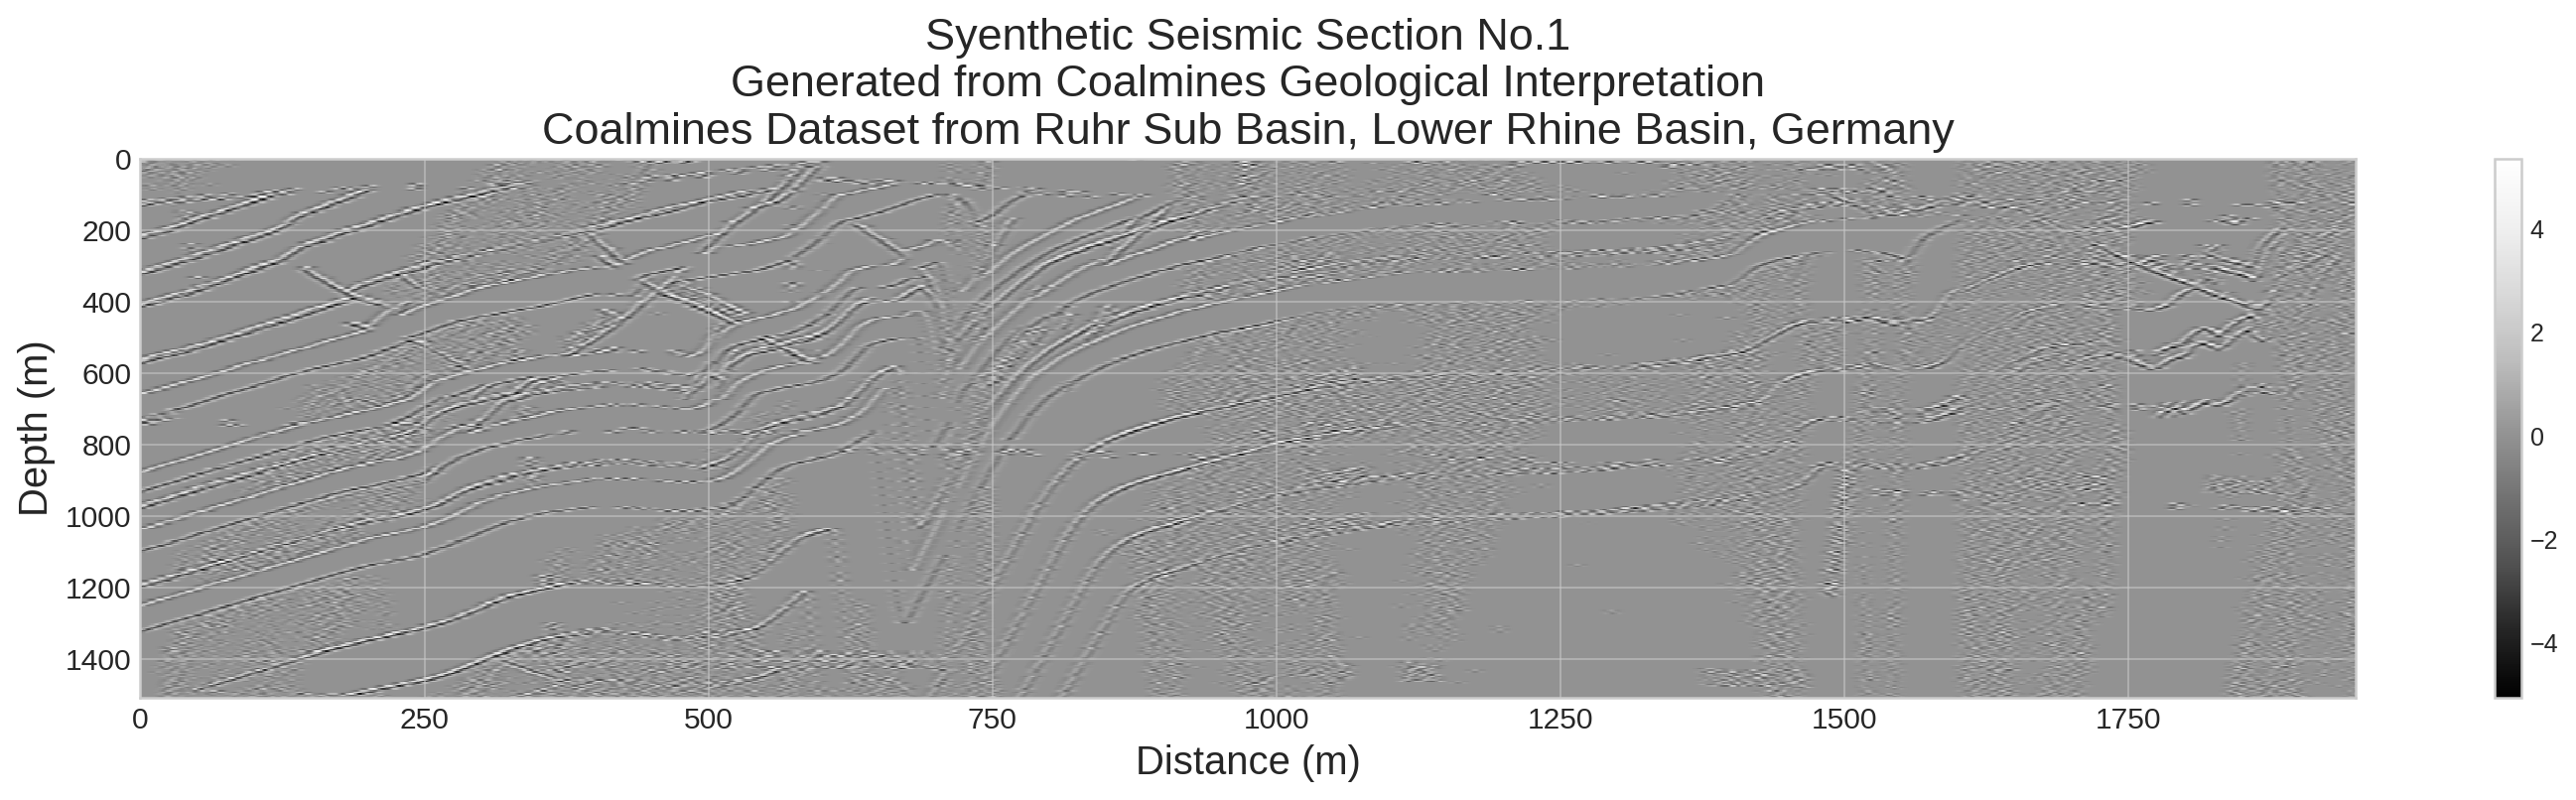

<Figure size 1440x288 with 0 Axes>

In [95]:
fig_size = (20,4)
plt.rcParams["figure.figsize"] = fig_size
plt.figure(figsize=fig_size, dpi= 180)
plt.style.use('seaborn-whitegrid')


# Headline title
text = chart_title
# Decorations
plt.title(chart_title, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.imshow(synth, cmap="Greys", aspect=4)

pcm = plt.imshow(synth, interpolation='nearest', cmap= 'Greys_r', # gray
                 origin='upper', aspect='auto',  # vmin = 0, vmax = 1,
                 extent =[0,
                          synth.shape[1],
                          synth.shape[0]*4.4,
                          0])

plt.grid(linestyle='-', alpha=0.5)
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Depth (m)', fontsize=16)

# # divider1 = make_axes_locatable()
# cax2 = divider1.append_axes("right", size="3%", pad=0.07)
plt.colorbar(pcm)

plt.figure()
plt.show();

## Helper Functions 

Let us put together two helper functions to generate the acoustic impedance and synthetic seismic sections.

### Acoustic Impedance Sections

In [ ]:
def generate_acoustic_impedance(folder_dir):
    directory = "Acoustic_impedance_images"
    dir = Path(folder_dir)
    path = os.path.join(dir, directory)
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully!" % directory)
    except OSError as error:
        print("Directory '%s' can not be created, already exist!" % directory)
    dir = Path(folder_dir + '/' + directory)
    
    for image in glob.iglob(f'{folder_dir}/*'):
        if (image.endswith(".png")):
            a = image.split("\\")[-1]
            a = a.split(".")[-2]
            word=r"Section"
            lword=len(word)
            start_index=re.search(word,a).start()
#             sections_names.append(a[start_index:start_index+lword+4])
#             sec_data[a[start_index:start_index+lword+4]] = digitise_data_section(cv2.imread(image))
        
            model = digitise_data_section(cv2.imread(image))
            test = np.where(model > 150, model, model*0)
            test = np.where(((test < 150) | (test > 210)), test, test*0+1)
            test = np.where(test < 210, test, test*0+2)
            model_rck = test.copy()
            earth = rocks_layers[model_rck]
            imp = np.apply_along_axis(np.product, -1, earth)
            rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
            
            fig_size = (12,4)
            plt.rcParams["figure.figsize"] = fig_size
            plt.figure(figsize=fig_size, dpi= 180)
            plt.style.use('seaborn-whitegrid')
            chart_title ="Acoustic Impedance {}".format(a[start_index:start_index+lword+4]) + "\nGenerated from Coalmines Geological Interpretation" + "\nCoalmines Dataset from Ruhr Sub Basin, Lower Rhine Basin, Germany" 

            text = chart_title
            plt.title(chart_title, fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            pcm = plt.imshow(rc, cmap='Greys', origin='upper', aspect='auto',  # vmin = 0, vmax = 1,
                             extent =[0,
                                      rc.shape[1],
                                      rc.shape[0]*4.4,
                                      0])

            plt.grid(linestyle='-', alpha=0.5)
            plt.xlabel('Distance (m)', fontsize=12)
            plt.ylabel('Depth (m)', fontsize=12)
            plt.colorbar(pcm)
            
#             plt.title(chart_title_output, fontsize=16, pad=10) 
#             plt.suptitle(chart_title_input, size=16, y=0.93) 
            plt.tight_layout()
            fn = dir / "acoustic_impedance_{}.png".format(a[start_index:start_index+lword+4])
            plt.savefig(fn)
            plt.close()

## Synthetic Seismic Sections

In [185]:
def generate_synthetic_seismic(folder_dir):
    directory = "Synthetic_Seismic_Images"
    dir = Path(folder_dir)
    path = os.path.join(dir, directory)
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully!" % directory)
    except OSError as error:
        print("Directory '%s' can not be created, already exist!" % directory)
    dir = Path(folder_dir + '/' + directory)
    
    for image in glob.iglob(f'{folder_dir}/*'):
        if (image.endswith(".png")):
            a = image.split("\\")[-1]
            a = a.split(".")[-2]
            word=r"Section"
            lword=len(word)
            start_index=re.search(word,a).start()

#             sections_names.append(a[start_index:start_index+lword+4])
#             sec_data[a[start_index:start_index+lword+4]] = digitise_data_section(cv2.imread(image))
        
            model = digitise_data_section(cv2.imread(image))
            test = np.where(model > 150, model, model*0)
            test = np.where(((test < 150) | (test > 210)), test, test*0+1)
            test = np.where(test < 210, test, test*0+2)
            model_rck = test.copy()
            earth = rocks_layers[model_rck]
            imp = np.apply_along_axis(np.product, -1, earth)
            rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
            T, dt, f = 0.256, 0.001, 45 # 65
            w, t= bruges.filters.ricker(T, dt, f, return_t=True)
            synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=1, arr=rc)
            
            
            fig_size = (12,4)
            plt.rcParams["figure.figsize"] = fig_size
            plt.figure(figsize=fig_size, dpi= 180)
            plt.style.use('seaborn-whitegrid')
            chart_title ="Syenthetic Seismic {}".format(a[start_index:start_index+lword+4]) + "\nGenerated from Coalmines Geological Interpretation" + "\nCoalmines Dataset from Ruhr Sub Basin, Lower Rhine Basin, Germany" 

            text = chart_title
            plt.title(chart_title, fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            pcm = plt.imshow(synth, interpolation='nearest', cmap= 'Greys_r', # gray
                             origin='upper', aspect='auto',  # vmin = 0, vmax = 1,
                             extent =[0,
                                      synth.shape[1],
                                      synth.shape[0]*4.4,
                                      0])

            plt.grid(linestyle='-', alpha=0.5)
            plt.xlabel('Distance (m)', fontsize=12)
            plt.ylabel('Depth (m)', fontsize=12)
            plt.colorbar(pcm)
            
#             plt.title(chart_title_output, fontsize=16, pad=10) 
#             plt.suptitle(chart_title_input, size=16, y=0.93) 
            plt.tight_layout()
            fn = dir / "synthetic_section_{}.png".format(a[start_index:start_index+lword+4])
            plt.savefig(fn)
            plt.close() 

# Application of the workflow on Ruhr Coalmines dataset.

## Ruhr Coalmines DataSet

## 1. Results - Emscher West Ruhrgebit Map - Area-1

In [188]:
folder_dir_1 = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-1'

Now we can apply the functions we generated to create an acoustic impedance and synthetic sections. This fuction will create a folder for the acoustic impedance and synthetic sections in the directory if the raw data.

In [189]:
generate_acoustic_impedance(folder_dir_1)

Directory 'Acoustic_impedance_images' can not be created, already exist!


In [190]:
generate_synthetic_seismic(folder_dir_1)

Directory 'Synthetic_Seismic_Images' can not be created, already exist!


## 2. Results - Emscher Middle Ruhr Sub-Basin - Area-2

In [182]:
folder_dir_2 = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-2/Study-Area-2-img-data'

In [183]:
generate_acoustic_impedance(folder_dir_2)

Directory 'Acoustic_impedance_images' can not be created, already exist!


In [186]:
generate_synthetic_seismic(folder_dir_2)

Directory 'Synthetic_Seismic_Images' can not be created, already exist!


## 3. Results - Bochumer Hauptmulde im ostl Ruhrgebiet - Area-3

In [169]:
folder_dir_3 = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-3/3.Final_Bochumer_Hauptmulde_im_ostl_Ruhrgebiet_G2'

In [176]:
generate_acoustic_impedance(folder_dir_3)

Directory 'Acoustic_impedance_images' can not be created, already exist


In [187]:
generate_synthetic_seismic(folder_dir_3)

Directory 'Synthetic_Seismic_Images' can not be created, already exist!


## 4. Results - Aachen Erkelenzer Steinkohlen - Area-4

### Substudy Area (A)

In [191]:
folder_dir_area_4_A = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-4/Final_Aachen_Erkelenzer_Steinkohlen_G3/studay-area-4-1-A'

In [192]:
generate_acoustic_impedance(folder_dir_area_4_A)

Directory 'Acoustic_impedance_images' created successfully!


In [193]:
generate_synthetic_seismic(folder_dir_area_4_A)

Directory 'Synthetic_Seismic_Images' created successfully!


### Substudy Area (B)

In [194]:
folder_dir_area_4_B = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-4/Final_Aachen_Erkelenzer_Steinkohlen_G3/studay-area-4-2-B'

In [195]:
generate_acoustic_impedance(folder_dir_area_4_B)

Directory 'Acoustic_impedance_images' created successfully!


In [196]:
generate_synthetic_seismic(folder_dir_area_4_B)

Directory 'Synthetic_Seismic_Images' created successfully!


### Substudy Area (C)

In [197]:
folder_dir_area_4_C = r'/content/drive/MyDrive/1.Raw-image-Data/Study-Area-4/Final_Aachen_Erkelenzer_Steinkohlen_G3/studay-area-4-3-C'

In [198]:
generate_acoustic_impedance(folder_dir_area_4_C)

Directory 'Acoustic_impedance_images' created successfully!


In [199]:
generate_synthetic_seismic(folder_dir_area_4_C)

Directory 'Synthetic_Seismic_Images' created successfully!


## Example Sections

### Study Area-1

![](https://i.imgur.com/KxccI6k.png)

![](https://i.imgur.com/cQJ0fvB.png)

![](https://i.imgur.com/TKLbeLM.png)

## Study Area-2

![](https://i.imgur.com/QLZfusK.png)

![](https://i.imgur.com/L2unsfo.png)

![](https://i.imgur.com/BTfQHvd.png)

## Study Area-3

![](https://i.imgur.com/S6gMv8k.png)

![](https://i.imgur.com/b3OvHYl.png)

![](https://i.imgur.com/BTfQHvd.png)

## Study Area-4

### Substudy Area-4-A

![](https://i.imgur.com/fKBdwgD.png)

![](https://i.imgur.com/MdtI6FO.png)

![](https://i.imgur.com/VTysQ2f.png)

### Substudy Area-4-B

![](https://i.imgur.com/H1EMC4t.png)

![](https://i.imgur.com/qIJeZEF.png)

![](https://i.imgur.com/pL57dTp.png)

### Substudy Area-4-C

![](https://i.imgur.com/kS8eKol.png)

![](https://i.imgur.com/19dl6RP.png)

![](https://i.imgur.com/k2y7DBW.png)

## References

Agile Scientific's  - x lines of code - Wedge model 

1. https://github.com/agilescientific/xlines/blob/master/notebooks/00_Synthetic_wedge_model.ipynb

2. https://github.com/agilescientific/xlines/tree/master/notebooks

3. https://github.com/mycarta/faults/blob/master/Multiple_synthetic_seismic_models_with_fault.ipynb

4. Seismic Synthetics with Devito and GemPy
https://github.com/devitocodes/transform2021

5. Creating seismic synthetics with Devito and GemPy https://github.com/devitocodes/transform2021/blob/main/creating_synthetics.ipynb

**Thank you!**

**By: Ramy Abdallah**